# One-Way Sensitivity Analysis: Tornado Diagram

## Outcome metric
**Intention-to-treat hazard ratio for MCI progression** — pipeline entrants in the
treatment scenario vs CRN-matched controls in the testing-only scenario, measured from
BBBM entry.

## Parameters varied

| # | Parameter | Default | Low | High | Affects |
|---|-----------|---------|-----|------|--------|
| 1 | Treatment RR | 0.528 | 0.4 | 0.6 | treat only |
| 2 | Treatment effect duration | 12 ts (6 yr) | 6 ts | 18 ts | treat only |
| 3 | Waning effect duration | 22 ts (11 yr) | 11 ts | 33 ts | treat only |
| 4 | Treatment acceptance ceiling | 0.8 | 0.5 | 1.0 | treat only |
| 5 | Treatment completion prob | 0.9 | 0.7 | 1.0 | treat only |
| 6 | BBBM testing rate plateau | 0.6 | 0.3 | 0.9 | both |
| 7 | BBBM positive diagnosis prob | 0.5 | 0.3 | 0.7 | both |
| 8 | Weibull scale (BBBM duration) | 6.76 | 5.0 | 9.0 | both |
| 9 | Testing start date | 2027 | 2025 | 2032 | both |

## Run count
- 2 baseline runs (ctrl + treat)
- 5 treat-only params x 2 extremes = 10 treat-only runs
- 4 both-scenario params x 2 extremes x 2 scenarios = 16 runs
- **Total: 28 simulation runs**

In [1]:
import copy
import math
import warnings
from contextlib import contextmanager

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from lifelines import CoxPHFitter, KaplanMeierFitter
from tqdm.auto import tqdm
from vivarium import InteractiveContext

from loguru import logger
logger.disable("vivarium")

# --- Constants ---
SPEC_PATH = '../src/vivarium_csu_alzheimers/model_specifications/model_spec.yaml'
POPULATION_SIZE = 10_000
STEP_SIZE_DAYS = 182
STEP_SIZE_YEARS = STEP_SIZE_DAYS / 365.25

DISEASE_COL = 'alzheimers_disease_and_other_dementias'
BBBM_STATE = 'alzheimers_blood_based_biomarker_state'
MCI_STATE = 'alzheimers_mild_cognitive_impairment_state'
DEMENTIA_STATE = 'alzheimers_disease_state'
TREATMENT_COL = 'treatment'
TARGET_YEAR = 2070
TREATMENT_RR = 0.528

In [2]:
# --- Parameter definitions for sensitivity analysis ---
PARAMETERS = [
    {
        'name': 'treatment_rr',
        'label': 'Treatment RR',
        'default': 0.528,
        'low': 0.4,
        'high': 0.6,
        'affects': 'treat',
    },
    {
        'name': 'treatment_effect_duration',
        'label': 'Treatment effect duration (timesteps)',
        'default': 12,
        'low': 6,
        'high': 18,
        'affects': 'treat',
    },
    {
        'name': 'waning_effect_duration',
        'label': 'Waning effect duration (timesteps)',
        'default': 22,
        'low': 11,
        'high': 33,
        'affects': 'treat',
    },
    {
        'name': 'treatment_acceptance_ceiling',
        'label': 'Treatment acceptance ceiling',
        'default': 0.8,
        'low': 0.5,
        'high': 1.0,
        'affects': 'treat',
    },
    {
        'name': 'treatment_completion_prob',
        'label': 'Treatment completion prob',
        'default': 0.9,
        'low': 0.7,
        'high': 1.0,
        'affects': 'treat',
    },
    {
        'name': 'testing_rate_plateau',
        'label': 'BBBM testing rate plateau',
        'default': 0.6,
        'low': 0.3,
        'high': 0.9,
        'affects': 'both',
    },
    {
        'name': 'positive_diagnosis_prob',
        'label': 'BBBM positive diagnosis prob',
        'default': 0.5,
        'low': 0.3,
        'high': 0.7,
        'affects': 'both',
    },
    {
        'name': 'weibull_scale',
        'label': 'Weibull scale (BBBM duration)',
        'default': 6.76,
        'low': 5.0,
        'high': 9.0,
        'affects': 'both',
    },
    {
        'name': 'testing_start_date',
        'label': 'Testing start year',
        'default': 2027,
        'low': 2025,
        'high': 2032,
        'affects': 'both',
    },
]

In [3]:
import vivarium_csu_alzheimers.constants.data_values as dv_mod
import vivarium_csu_alzheimers.components.treatment as treat_mod
import vivarium_csu_alzheimers.components.testing as test_mod
import vivarium_csu_alzheimers.components.alzheimers as alz_mod
import vivarium_csu_alzheimers.data.consistent_rates as cr_mod
# Note: loader.py cannot be imported (missing vivarium_inputs dep), but it
# accesses data_values.BBBM_AVG_DURATION via the module reference so patching
# dv_mod is sufficient.


@contextmanager
def patch_params(param_name, value):
    """
    Context manager that patches simulation parameters in all relevant modules.

    Python's `from module import NAME` creates a local binding, so we must
    patch BOTH the source module (data_values) AND every consuming module.
    For mutable objects (lists), we mutate in-place and restore on exit.
    """
    saved = {}  # {(module, attr): old_value}

    def _save_and_set(mod, attr, new_val):
        saved[(mod, attr)] = getattr(mod, attr)
        setattr(mod, attr, new_val)

    try:
        if param_name == 'treatment_rr':
            # Monkey-patch TreatmentRiskEffect.load_relative_risk to return
            # the desired RR value instead of reading from the artifact.
            orig_method = treat_mod.TreatmentRiskEffect.load_relative_risk
            saved[('_rr_method', None)] = orig_method
            rr_val = value
            def patched_load_rr(self, builder, configuration=None):
                return rr_val
            treat_mod.TreatmentRiskEffect.load_relative_risk = patched_load_rr

        elif param_name == 'treatment_effect_duration':
            ts = int(value)
            _save_and_set(dv_mod, 'DWELL_TIME_TREATMENT_EFFECT_TIMESTEPS', ts)
            _save_and_set(treat_mod, 'DWELL_TIME_TREATMENT_EFFECT_TIMESTEPS', ts)

        elif param_name == 'waning_effect_duration':
            ts = int(value)
            _save_and_set(dv_mod, 'DWELL_TIME_WANING_EFFECT_TIMESTEPS', ts)
            _save_and_set(treat_mod, 'DWELL_TIME_WANING_EFFECT_TIMESTEPS', ts)

        elif param_name == 'treatment_acceptance_ceiling':
            # TREATMENT_PROBS_RAMP is a list — mutate in-place (shared reference).
            # Save a deep copy of the original.
            orig_ramp = copy.deepcopy(dv_mod.TREATMENT_PROBS_RAMP)
            saved[('_treat_ramp', None)] = orig_ramp
            # The last entry is the ceiling: (Timestamp('2100-01-01'), ceiling)
            # Scale the intermediate points proportionally.
            default_ceiling = 0.8
            scale = value / default_ceiling
            for i in range(len(dv_mod.TREATMENT_PROBS_RAMP)):
                ts_val, rate = dv_mod.TREATMENT_PROBS_RAMP[i]
                dv_mod.TREATMENT_PROBS_RAMP[i] = (ts_val, rate * scale)

        elif param_name == 'treatment_completion_prob':
            _save_and_set(dv_mod, 'TREATMENT_COMPLETION_PROBABILITY', value)
            _save_and_set(treat_mod, 'TREATMENT_COMPLETION_PROBABILITY', value)

        elif param_name == 'testing_rate_plateau':
            # BBBM_TESTING_RATES is a list — mutate in-place.
            orig_rates = copy.deepcopy(dv_mod.BBBM_TESTING_RATES)
            saved[('_test_rates', None)] = orig_rates
            # Scale all rate values proportionally so the plateau matches `value`.
            default_plateau = 0.6
            scale = value / default_plateau
            for i in range(len(dv_mod.BBBM_TESTING_RATES)):
                ts_val, rate = dv_mod.BBBM_TESTING_RATES[i]
                dv_mod.BBBM_TESTING_RATES[i] = (ts_val, rate * scale)

        elif param_name == 'positive_diagnosis_prob':
            _save_and_set(dv_mod, 'BBBM_POSITIVE_DIAGNOSIS_PROBABILITY', value)
            _save_and_set(test_mod, 'BBBM_POSITIVE_DIAGNOSIS_PROBABILITY', value)

        elif param_name == 'weibull_scale':
            new_dist = scipy.stats.weibull_min(dv_mod.WEIBULL_SHAPE, scale=value)
            new_avg = new_dist.mean()
            _save_and_set(dv_mod, 'WEIBULL_SCALE', value)
            _save_and_set(dv_mod, 'BBBM_HAZARD_DIST', new_dist)
            _save_and_set(dv_mod, 'BBBM_AVG_DURATION', new_avg)
            # Patch consuming modules
            _save_and_set(alz_mod, 'BBBM_HAZARD_DIST', new_dist)
            _save_and_set(alz_mod, 'BBBM_AVG_DURATION', new_avg)
            _save_and_set(cr_mod, 'BBBM_AVG_DURATION', new_avg)
            # loader.py accesses data_values.BBBM_AVG_DURATION via module ref, so
            # patching dv_mod is sufficient for loader.

        elif param_name == 'testing_start_date':
            new_start = pd.Timestamp(f'{int(value)}-01-01')
            # Mutate BBBM_TESTING_RATES in-place: shift the first entry.
            orig_rates = copy.deepcopy(dv_mod.BBBM_TESTING_RATES)
            saved[('_test_rates_start', None)] = orig_rates
            dv_mod.BBBM_TESTING_RATES[0] = (new_start, dv_mod.BBBM_TESTING_RATES[0][1])
            # Update the derived constant
            _save_and_set(dv_mod, 'BBBM_TESTING_START_DATE', new_start)
            _save_and_set(test_mod, 'BBBM_TESTING_START_DATE', new_start)

        else:
            raise ValueError(f'Unknown parameter: {param_name}')

        yield

    finally:
        # Restore all saved scalar attributes
        for (mod, attr), old_val in saved.items():
            if attr is not None:
                setattr(mod, attr, old_val)

        # Restore monkey-patched method
        if ('_rr_method', None) in saved:
            treat_mod.TreatmentRiskEffect.load_relative_risk = saved[('_rr_method', None)]

        # Restore mutated lists
        if ('_treat_ramp', None) in saved:
            orig = saved[('_treat_ramp', None)]
            for i in range(len(orig)):
                dv_mod.TREATMENT_PROBS_RAMP[i] = orig[i]

        if ('_test_rates', None) in saved:
            orig = saved[('_test_rates', None)]
            for i in range(len(orig)):
                dv_mod.BBBM_TESTING_RATES[i] = orig[i]

        if ('_test_rates_start', None) in saved:
            orig = saved[('_test_rates_start', None)]
            for i in range(len(orig)):
                dv_mod.BBBM_TESTING_RATES[i] = orig[i]

/home/abie/miniforge3/envs/vivarium_csu_alzheimers_simulation/lib/python3.11/site-packages/vivarium_public_health/plugins/parser.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [4]:
def run_scenario(scenario, target_year=TARGET_YEAR):
    """
    Run a single scenario and track per-simulant events.

    Returns a dict with:
      bbbm_enter_time, bbbm_exit_time, bbbm_exit_to,
      death_time, pipeline_time, treatment_effect_start,
      treatment_effect_end, waning_effect_end, refusal_time, sim_end
    """
    sim = InteractiveContext(
        SPEC_PATH,
        configuration={
            'population': {'population_size': POPULATION_SIZE},
            'intervention': {'scenario': scenario},
        }
    )

    target = pd.Timestamp(f'{target_year}-01-01')
    est_steps = max(1, math.ceil((target - sim.current_time).days / STEP_SIZE_DAYS))

    in_bbbm = set()
    alive_set = set()
    bbbm_enter_time = {}
    bbbm_exit_time = {}
    bbbm_exit_to = {}
    death_time = {}
    pipeline_time = {}
    treatment_effect_start = {}
    treatment_effect_end = {}
    waning_effect_end = {}
    refusal_time = {}
    prev_treatment = {}

    is_treatment = (scenario == 'bbbm_testing_and_treatment')

    with tqdm(total=est_steps, desc=scenario.replace('bbbm_', ''), unit='step') as pbar:
        while sim.current_time < target:
            sim.step()
            pop = sim.get_population()
            alive = pop[pop['alive'] == 'alive']
            t = sim.current_time
            current_alive = set(alive.index)

            for sid in alive_set - current_alive:
                if sid not in death_time:
                    death_time[sid] = t

            currently_bbbm = set(alive.index[alive[DISEASE_COL] == BBBM_STATE])
            for sid in currently_bbbm - in_bbbm:
                if sid not in bbbm_enter_time:
                    bbbm_enter_time[sid] = t
            for sid in in_bbbm - currently_bbbm:
                if sid not in bbbm_exit_time:
                    bbbm_exit_time[sid] = t
                    bbbm_exit_to[sid] = 'mci' if sid in current_alive else 'dead'
            in_bbbm = currently_bbbm
            alive_set = current_alive

            if is_treatment and TREATMENT_COL in alive.columns:
                for sid in alive.index:
                    state = alive.loc[sid, TREATMENT_COL]
                    prev = prev_treatment.get(sid)

                    if state == 'waiting_for_treatment' and prev != 'waiting_for_treatment':
                        if sid not in pipeline_time:
                            pipeline_time[sid] = t
                    if state == 'treatment_effect' and prev != 'treatment_effect':
                        if sid not in treatment_effect_start:
                            treatment_effect_start[sid] = t
                    if prev == 'treatment_effect' and state != 'treatment_effect':
                        if sid not in treatment_effect_end:
                            treatment_effect_end[sid] = t
                    if prev == 'waning_effect' and state != 'waning_effect':
                        if sid not in waning_effect_end:
                            waning_effect_end[sid] = t
                    if state == 'no_effect_never_treated' and sid not in refusal_time:
                        refusal_time[sid] = t

                    prev_treatment[sid] = state

                for sid in set(prev_treatment.keys()) - current_alive:
                    prev = prev_treatment.get(sid)
                    if prev == 'treatment_effect' and sid not in treatment_effect_end:
                        treatment_effect_end[sid] = t
                    if prev == 'waning_effect' and sid not in waning_effect_end:
                        waning_effect_end[sid] = t

            pbar.update(1)

    return {
        'bbbm_enter_time': bbbm_enter_time,
        'bbbm_exit_time': bbbm_exit_time,
        'bbbm_exit_to': bbbm_exit_to,
        'death_time': death_time,
        'pipeline_time': pipeline_time,
        'treatment_effect_start': treatment_effect_start,
        'treatment_effect_end': treatment_effect_end,
        'waning_effect_end': waning_effect_end,
        'refusal_time': refusal_time,
        'sim_end': sim.current_time,
    }

In [5]:
def compute_itt_hr(treat_data, ctrl_data):
    """
    Build ITT KM data (pipeline entrants in treatment scenario vs CRN-matched
    controls in testing-only scenario) and compute the Cox PH hazard ratio.

    Returns: (hr, hr_lo, hr_hi)
    """
    sim_end = treat_data['sim_end']
    records = []

    for sid in treat_data['pipeline_time']:
        for data, group in [(treat_data, 'treated'), (ctrl_data, 'control')]:
            t0 = data['bbbm_enter_time'].get(sid)
            if t0 is None:
                continue
            bbbm_exit = data['bbbm_exit_time'].get(sid)
            bbbm_dest = data['bbbm_exit_to'].get(sid)

            if bbbm_dest == 'mci' and bbbm_exit is not None:
                dur = (bbbm_exit - t0).days / 365.25
                evt = 1
            elif bbbm_dest == 'dead' and bbbm_exit is not None:
                dur = (bbbm_exit - t0).days / 365.25
                evt = 0
            else:
                dur = (sim_end - t0).days / 365.25
                evt = 0
            if dur > 0:
                records.append({'duration': dur, 'event': evt, 'group': group})

    df = pd.DataFrame(records)
    if df.empty or df['group'].nunique() < 2:
        return (np.nan, np.nan, np.nan)

    t_mask = df['group'] == 'treated'
    c_mask = ~t_mask

    cox_df = pd.DataFrame({
        'duration': df['duration'].values,
        'event': df['event'].values,
        'treated': (df['group'] == 'treated').astype(float).values,
    })
    cox_df = cox_df[cox_df['duration'] > 0]

    cph = CoxPHFitter()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cph.fit(cox_df, duration_col='duration', event_col='event')

    hr = cph.hazard_ratios_['treated']
    ci = cph.confidence_intervals_.loc['treated']
    return (hr, np.exp(ci.iloc[0]), np.exp(ci.iloc[1]))

In [6]:
# --- Baseline run (default parameters) ---
print('Running baseline CTRL scenario...')
baseline_ctrl = run_scenario('bbbm_testing')
print(f'  {len(baseline_ctrl["bbbm_exit_time"]):,} BBBM exits')

print('Running baseline TREAT scenario...')
baseline_treat = run_scenario('bbbm_testing_and_treatment')
print(f'  {len(baseline_treat["bbbm_exit_time"]):,} BBBM exits, '
      f'{len(baseline_treat["pipeline_time"]):,} pipeline entrants')

baseline_hr, baseline_hr_lo, baseline_hr_hi = compute_itt_hr(baseline_treat, baseline_ctrl)
print(f'\nBaseline ITT HR = {baseline_hr:.3f} ({baseline_hr_lo:.3f}-{baseline_hr_hi:.3f})')

Running baseline CTRL scenario...


testing:   0%|          | 0/97 [00:00<?, ?step/s]

  86,013 BBBM exits
Running baseline TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  85,783 BBBM exits, 3,969 pipeline entrants

Baseline ITT HR = 0.612 (0.578-0.647)


In [7]:
# --- Sensitivity loop ---
results = []

for param in PARAMETERS:
    name = param['name']
    label = param['label']
    affects = param['affects']

    for extreme_label, extreme_val in [('low', param['low']), ('high', param['high'])]:
        print(f"\n{'='*60}")
        print(f'{label} = {extreme_val} ({extreme_label})')
        print(f"{'='*60}")

        with patch_params(name, extreme_val):
            if affects == 'treat':
                # Only re-run the treatment scenario; reuse baseline ctrl
                print('  Running TREAT scenario...')
                treat = run_scenario('bbbm_testing_and_treatment')
                ctrl = baseline_ctrl
            else:
                # Re-run both scenarios
                print('  Running CTRL scenario...')
                ctrl = run_scenario('bbbm_testing')
                print('  Running TREAT scenario...')
                treat = run_scenario('bbbm_testing_and_treatment')

            hr, hr_lo, hr_hi = compute_itt_hr(treat, ctrl)

        n_pipeline = len(treat['pipeline_time'])
        print(f'  Pipeline entrants: {n_pipeline:,}')
        print(f'  ITT HR = {hr:.3f} ({hr_lo:.3f}-{hr_hi:.3f})')

        results.append({
            'param': name,
            'label': label,
            'extreme': extreme_label,
            'value': extreme_val,
            'hr': hr,
            'hr_lo': hr_lo,
            'hr_hi': hr_hi,
        })

results_df = pd.DataFrame(results)
print('\nSensitivity loop complete.')


Treatment RR = 0.4 (low)
  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 3,969
  ITT HR = 0.514 (0.485-0.545)

Treatment RR = 0.6 (high)
  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 3,969
  ITT HR = 0.665 (0.629-0.704)

Treatment effect duration (timesteps) = 6 (low)
  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 3,969
  ITT HR = 0.654 (0.618-0.691)

Treatment effect duration (timesteps) = 18 (high)
  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 3,969
  ITT HR = 0.592 (0.559-0.626)

Waning effect duration (timesteps) = 11 (low)
  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 3,969
  ITT HR = 0.636 (0.601-0.673)

Waning effect duration (timesteps) = 33 (high)
  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 3,969
  ITT HR = 0.600 (0.566-0.635)

Treatment acceptance ceiling = 0.5 (low)
  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 2,458
  ITT HR = 0.599 (0.557-0.644)

Treatment acceptance ceiling = 1.0 (high)
  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 4,960
  ITT HR = 0.619 (0.589-0.652)

Treatment completion prob = 0.7 (low)
  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 3,969
  ITT HR = 0.619 (0.585-0.655)

Treatment completion prob = 1.0 (high)
  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 3,969
  ITT HR = 0.608 (0.574-0.643)

BBBM testing rate plateau = 0.3 (low)
  Running CTRL scenario...


testing:   0%|          | 0/97 [00:00<?, ?step/s]

  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 1,995
  ITT HR = 0.616 (0.569-0.667)

BBBM testing rate plateau = 0.9 (high)
  Running CTRL scenario...


testing:   0%|          | 0/97 [00:00<?, ?step/s]

  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 5,986
  ITT HR = 0.618 (0.590-0.647)

BBBM positive diagnosis prob = 0.3 (low)
  Running CTRL scenario...


testing:   0%|          | 0/97 [00:00<?, ?step/s]

  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 2,520
  ITT HR = 0.610 (0.568-0.656)

BBBM positive diagnosis prob = 0.7 (high)
  Running CTRL scenario...


testing:   0%|          | 0/97 [00:00<?, ?step/s]

  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 5,236
  ITT HR = 0.615 (0.586-0.646)

Weibull scale (BBBM duration) = 5.0 (low)
  Running CTRL scenario...


testing:   0%|          | 0/97 [00:00<?, ?step/s]

  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 3,409
  ITT HR = 0.611 (0.577-0.648)

Weibull scale (BBBM duration) = 9.0 (high)
  Running CTRL scenario...


testing:   0%|          | 0/97 [00:00<?, ?step/s]

  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 4,416
  ITT HR = 0.638 (0.602-0.676)

Testing start year = 2025 (low)
  Running CTRL scenario...


testing:   0%|          | 0/97 [00:00<?, ?step/s]

  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 3,966
  ITT HR = 0.612 (0.579-0.648)

Testing start year = 2032 (high)
  Running CTRL scenario...


testing:   0%|          | 0/97 [00:00<?, ?step/s]

  Running TREAT scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  Pipeline entrants: 3,959
  ITT HR = 0.611 (0.577-0.647)

Sensitivity loop complete.


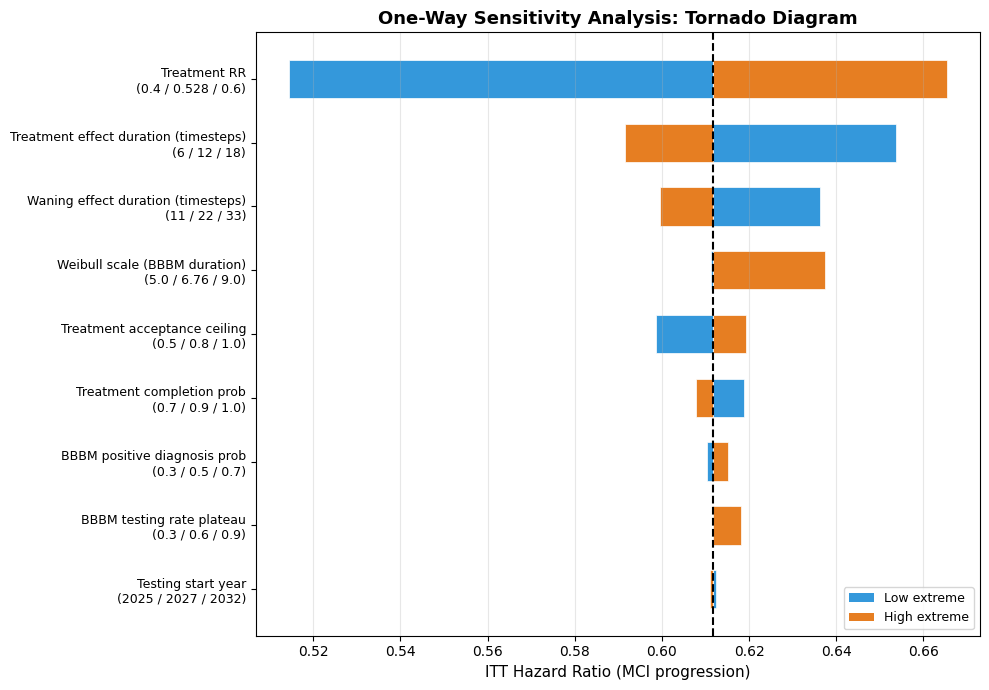

In [8]:
# --- Tornado diagram ---

# Pivot results to get low and high HR per parameter
pivot = results_df.pivot(index='param', columns='extreme', values='hr')

# Build display data aligned with PARAMETERS order
param_order = [p['name'] for p in PARAMETERS]
labels = []
hr_low = []
hr_high = []
for p in PARAMETERS:
    name = p['name']
    labels.append(f"{p['label']}\n({p['low']} / {p['default']} / {p['high']})")
    hr_low.append(pivot.loc[name, 'low'])
    hr_high.append(pivot.loc[name, 'high'])

hr_low = np.array(hr_low)
hr_high = np.array(hr_high)

# Sort by swing width (widest at top)
swing = np.abs(hr_high - hr_low)
sort_idx = np.argsort(swing)  # ascending -> widest at top in barh

labels_sorted = [labels[i] for i in sort_idx]
hr_low_sorted = hr_low[sort_idx]
hr_high_sorted = hr_high[sort_idx]

fig, ax = plt.subplots(figsize=(10, 7))
y_pos = np.arange(len(labels_sorted))

for i in range(len(labels_sorted)):
    lo, hi = hr_low_sorted[i], hr_high_sorted[i]
    left = min(lo, hi)
    width = abs(hi - lo)

    # Blue for the portion below baseline, orange for above
    ax.barh(i, lo - baseline_hr, left=baseline_hr, height=0.6,
            color='#3498db', edgecolor='white', linewidth=0.5)
    ax.barh(i, hi - baseline_hr, left=baseline_hr, height=0.6,
            color='#e67e22', edgecolor='white', linewidth=0.5)

# Baseline reference line
ax.axvline(x=baseline_hr, color='black', linestyle='--', linewidth=1.5,
           label=f'Baseline HR = {baseline_hr:.3f}')

ax.set_yticks(y_pos)
ax.set_yticklabels(labels_sorted, fontsize=9)
ax.set_xlabel('ITT Hazard Ratio (MCI progression)', fontsize=11)
ax.set_title('One-Way Sensitivity Analysis: Tornado Diagram', fontsize=13, fontweight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', label='Low extreme'),
    Patch(facecolor='#e67e22', label='High extreme'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=9)
ax.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# --- Summary table ---
print(f'Baseline ITT HR = {baseline_hr:.3f} ({baseline_hr_lo:.3f}-{baseline_hr_hi:.3f})')
print(f'Population = {POPULATION_SIZE:,}, simulation to {TARGET_YEAR}')
print()

hdr = f'{"Parameter":40s} {"Extreme":>7s} {"Value":>8s} {"HR":>7s} {"95% CI":>17s} {"Delta":>8s}'
print(hdr)
print('-' * len(hdr))

for _, row in results_df.iterrows():
    delta = row['hr'] - baseline_hr
    print(f'{row["label"]:40s} {row["extreme"]:>7s} {row["value"]:>8.3g} '
          f'{row["hr"]:>7.3f} ({row["hr_lo"]:>.3f}-{row["hr_hi"]:>.3f}) '
          f'{delta:>+7.3f}')

Baseline ITT HR = 0.612 (0.578-0.647)
Population = 10,000, simulation to 2070

Parameter                                Extreme    Value      HR            95% CI    Delta
--------------------------------------------------------------------------------------------
Treatment RR                                 low      0.4   0.514 (0.485-0.545)  -0.097
Treatment RR                                high      0.6   0.665 (0.629-0.704)  +0.054
Treatment effect duration (timesteps)        low        6   0.654 (0.618-0.691)  +0.042
Treatment effect duration (timesteps)       high       18   0.592 (0.559-0.626)  -0.020
Waning effect duration (timesteps)           low       11   0.636 (0.601-0.673)  +0.025
Waning effect duration (timesteps)          high       33   0.600 (0.566-0.635)  -0.012
Treatment acceptance ceiling                 low      0.5   0.599 (0.557-0.644)  -0.013
Treatment acceptance ceiling                high        1   0.619 (0.589-0.652)  +0.008
Treatment completion prob      